In [1]:
import sys
sys.path.append('..')
import warnings
warnings.filterwarnings('ignore')

In [2]:
import torch
import torch.nn.functional as F
import numpy as np
from torchvision.datasets import MNIST
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from collections import OrderedDict
from torch.nn.parameter import Parameter
import matplotlib.pyplot as plt
from MogrifierLSTM import MogrifierLSTMCell
from utils.dataset import NCDFDatasets
from utils.evaluator import Evaluator
import adamod


In [3]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device
if (torch.cuda.is_available()):
    torch.cuda.empty_cache()

In [4]:
import random as rd
seed = 1000
np.random.seed(seed)
rd.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic=True

In [5]:
def init_seed(seed):
    np.random.seed(seed)
    
init_seed = init_seed(seed)

In [6]:
batch_size = 25
validation_split = 0.2
test_split = 0.2
layer_size = 3
dropout_rate = 0.2
out_channels = 64
kernel_size = 5
hidden_size = 2500
mogrify_rounds = 5

In [7]:
import xarray as xr
data_path = '../data/dataset-chirps-1981-2019-seq5-ystep5.nc'
dataset = xr.open_dataset(data_path)
print(dataset)

<xarray.Dataset>
Dimensions:  (channel: 1, lat: 50, lon: 50, sample: 13960, time: 5)
Coordinates:
  * lat      (lat) int64 -39 -38 -37 -36 -35 -34 -33 -32 ... 3 4 5 6 7 8 9 10
  * lon      (lon) int64 -84 -83 -82 -81 -80 -79 -78 ... -40 -39 -38 -37 -36 -35
Dimensions without coordinates: channel, sample, time
Data variables:
    x        (sample, time, lat, lon, channel) float32 ...
    y        (sample, time, lat, lon, channel) float32 ...
Attributes:
    description:  The variables have preciptation values and are separable in...


In [8]:
#In these experiments y has dimensions [batch, channel, lat, lon] as opposed to [batch, channel, time, lat, lon] to
#avoid dimension conflict with conv kernels
data = NCDFDatasets(dataset, val_split = validation_split, test_split = test_split)
train_data = data.get_train()
val_data = data.get_val()
test_data = data.get_test()

In [9]:
print("-----Train-----")
print("X : ", train_data.x.shape)
print("Y : ", train_data.y.shape)
print("-----Val-----")
print("X : ", val_data.x.shape)
print("Y : ", val_data.y.shape)
print("-----Test-----")
print("X : ", test_data.x.shape)
print("Y : ", test_data.y.shape)

-----Train-----
X :  torch.Size([8376, 1, 5, 50, 50])
Y :  torch.Size([8376, 1, 50, 50])
-----Val-----
X :  torch.Size([2792, 1, 5, 50, 50])
Y :  torch.Size([2792, 1, 50, 50])
-----Test-----
X :  torch.Size([2792, 1, 5, 50, 50])
Y :  torch.Size([2792, 1, 50, 50])


In [10]:
params = {'batch_size': batch_size,
          'num_workers': 4,
          'worker_init_fn': init_seed}

#Last batches with inconsistent size crash the mogrifierLSTM
train_loader = DataLoader(dataset=train_data, shuffle=True, drop_last=True,**params)
val_loader = DataLoader(dataset=val_data, shuffle=False, drop_last=True,**params)
test_loader = DataLoader(dataset=test_data, shuffle=False, drop_last=True,**params)

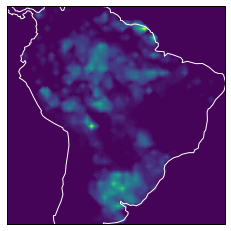

In [11]:
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import cartopy
#sample, ch, time, lat, lon
sst = train_data.y[0, 0, :, :]
lats = dataset.variables['lat'][:]
lons = dataset.variables['lon'][:]

ax = plt.axes(projection=ccrs.PlateCarree())

plt.contourf(lons, lats, sst, 60,
             transform=ccrs.PlateCarree())
ax.coastlines(color='white')

plt.show()

In [12]:
class Mish(torch.nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        #inlining this saves 1 second per epoch (V100 GPU) vs having a temp x and then returning x(!)
        return x *( torch.tanh(F.softplus(x)))

In [13]:
class CustomConv2d(torch.nn.Conv2d):
    def __init__(self, in_channels, out_channels, kernel_size, stride=1,
                 padding=0, dilation=1,
                 bias=False, padding_mode='zeros', weight=None):
        super().__init__(in_channels, out_channels, kernel_size, stride=stride,
                 padding=padding, dilation=dilation,
                 bias=bias, padding_mode=padding_mode)
        
        self.padding = [kernel_size // 2, kernel_size // 2]
        if (weight is not None):
            self.weight = Parameter(weight.permute(1,0,2,3))
        
    def forward(self,input):
        return F.conv2d(input, self.weight, self.bias, self.stride,
                        self.padding, self.dilation)

In [14]:
class EncoderCNN(torch.nn.Module):
    def __init__(self, layer_size, kernel_size, initial_out_channels, initial_in_channels):
        super(EncoderCNN, self).__init__()
        self.conv_layers = torch.nn.ModuleList()
        self.mish_layers = torch.nn.ModuleList()
        self.bn_layers = torch.nn.ModuleList()
        self.dropout_layers = torch.nn.ModuleList()
        
        in_channels = initial_in_channels
        out_channels = initial_out_channels
        for i in range(layer_size):
            if (i == layer_size-1):
                out_channels = 1
            self.conv_layers.append(CustomConv2d(in_channels = in_channels, out_channels = out_channels,
                                                kernel_size = kernel_size))
            self.mish_layers.append(Mish())
            self.bn_layers.append(torch.nn.BatchNorm2d(out_channels))
            self.dropout_layers.append(torch.nn.Dropout(dropout_rate))
            in_channels = out_channels
            
            
            
    def forward(self, x):
        for conv, bn, mish, dropout in zip(self.conv_layers, self.bn_layers, self.mish_layers, self.dropout_layers):
            x = conv(x)
            x = bn(x)
            x = mish(x)
            x = dropout(x)
        return x

In [15]:
class DecoderCNN(torch.nn.Module):
    def __init__(self, layer_size, kernel_size, initial_out_channels, initial_in_channels, encoder_weights):
        super(DecoderCNN, self).__init__()
        self.conv_layers = torch.nn.ModuleList()
        self.mish_layers = torch.nn.ModuleList()
        self.bn_layers = torch.nn.ModuleList()
        self.dropout_layers = torch.nn.ModuleList()
        
        in_channels = initial_in_channels
        out_channels = initial_out_channels
        
        for i in range(layer_size):
            if (i == layer_size-1):
                out_channels = 1
            self.conv_layers.append(CustomConv2d(in_channels = in_channels, out_channels = out_channels,
                                                kernel_size = kernel_size, weight=encoder_weights[i]))
            self.mish_layers.append(Mish())
            self.bn_layers.append(torch.nn.BatchNorm2d(out_channels))
            self.dropout_layers.append(torch.nn.Dropout(dropout_rate))

            in_channels = out_channels
            
    def forward(self, x):
        for conv, bn, mish, dropout in zip(self.conv_layers, self.bn_layers, self.mish_layers, self.dropout_layers):
            x = conv(x)
            x = bn(x)
            x = mish(x)
            x = dropout(x)
        return x

In [16]:
class STModel(torch.nn.Module):
    def __init__(self, layer_size, kernel_size, out_channels, in_channels, input_width, input_height, recurrent_hidden, 
                mogrify_rounds):
        super(STModel, self).__init__()
        self.encoder = EncoderCNN(layer_size = layer_size, kernel_size = kernel_size,
                                initial_out_channels = out_channels,
                                initial_in_channels = in_channels)
        encoder_weights = [layer.weight for layer in self.encoder.conv_layers][::-1]
        #self.recurrent = torch.nn.LSTM(input_width*input_height, recurrent_hidden, batch_first=True);
        self.recurrent = MogrifierLSTMCell(input_width*input_height, recurrent_hidden, mogrify_rounds)
        self.decoder = DecoderCNN(layer_size = layer_size, kernel_size = kernel_size,
                                initial_out_channels = out_channels,
                                initial_in_channels = in_channels, encoder_weights = encoder_weights)
        
        
    def forward(self, x, states):
        batch, channel, time, lat, lon = x.size()
        x_input = x.view(batch*time, channel, lat, lon)
        x = self.encoder(x_input)
        #flatten
        x = x.view(batch, time, -1)
        h = states[0]
        c = states[1]
        for i in range(time):
            h,c = self.recurrent(x[:,i,:],(h,c))
        #revert to original dimensions
        x = h.contiguous().view(batch, channel, lat, lon)
        x = self.decoder(x)
        return x, (h,c)
        

In [17]:
class RMSELoss(torch.nn.Module):
    def __init__(self, eps=1e-6):
        super().__init__()
        self.mse = torch.nn.MSELoss()
        self.eps = eps
        
    def forward(self,yhat,y):
        loss = torch.sqrt(self.mse(yhat,y) + self.eps)
        return loss


In [18]:
model = STModel(layer_size = layer_size, kernel_size = kernel_size, out_channels = out_channels, in_channels = train_data.x.shape[1], input_width = train_data.x.shape[3], input_height = train_data.x.shape[4], recurrent_hidden = hidden_size, mogrify_rounds = mogrify_rounds).to(device)
criterion = RMSELoss()
#optimizer_params = {'lr': 0.001}
#optimizer = torch.optim.Adam(net.parameters(), **optimizer_params)
opt_params = {'lr': 0.001, 
              'beta3': 0.999}
optimizer = adamod.AdaMod(model.parameters(), **opt_params)
model

STModel(
  (encoder): EncoderCNN(
    (conv_layers): ModuleList(
      (0): CustomConv2d(1, 64, kernel_size=(5, 5), stride=(1, 1), padding=[2, 2], bias=False)
      (1): CustomConv2d(64, 64, kernel_size=(5, 5), stride=(1, 1), padding=[2, 2], bias=False)
      (2): CustomConv2d(64, 1, kernel_size=(5, 5), stride=(1, 1), padding=[2, 2], bias=False)
    )
    (mish_layers): ModuleList(
      (0): Mish()
      (1): Mish()
      (2): Mish()
    )
    (bn_layers): ModuleList(
      (0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): BatchNorm2d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (dropout_layers): ModuleList(
      (0): Dropout(p=0.2, inplace=False)
      (1): Dropout(p=0.2, inplace=False)
      (2): Dropout(p=0.2, inplace=False)
    )
  )
  (recurrent): MogrifierLSTMCell(
    (x2h): Linear(in_features=2500, out_feature

In [19]:
class Evaluator:
    def __init__(self, model, loss, data_loader, device):
        self.model = model
        self.loss = loss
        self.data_loader = data_loader
        self.device = device
        
    def evaluate(self):
        with torch.no_grad():
            eval_loss = 0.0
            self.model.eval()
            for i, (x, y) in enumerate(self.data_loader):
                x,y = x.to(self.device), y.to(self.device)
                states = init_hidden(x.size()[0], x.size()[3]*x.size()[4])
                output, _ = self.model(x, states)
                loss = self.loss(output, y)
                eval_loss += loss.detach().item()
            avg_loss = eval_loss/len(self.data_loader)
        return avg_loss

In [20]:
class TrainingStop:
    def __init__(self, threshold):
        self.min_loss = sys.float_info.max
        self.count = 0
        self.threshold = threshold
        
    def check_stop_condition(self, curr_loss):
        if (curr_loss < self.min_loss):
            self.min_loss = curr_loss
            self.count = 0
            return False
        else:
            self.count += 1
            if (self.count >= self.threshold):
                return True
            return False

In [21]:
def init_hidden(batch_size, hidden_size):
    h = torch.zeros(batch_size,hidden_size, device=device)
    return (h,h)

#Might not be required, this is typically for BPTT to not backprop through the whole sequence between batches.
#Causes out of memory without this.
def repackage_hidden(states):
    if isinstance(states, torch.Tensor):
        return states.detach()
    else:
        return tuple(repackage_hidden(v) for v in states)

In [ ]:
train_losses, val_losses = [], []
evaluator = Evaluator(model, criterion, val_loader, device)
training_stopper = TrainingStop(3)
for epoch in range(1,100):
    train_loss = model.train()
    epoch_train_loss = 0.0
    for i, (x, y) in enumerate(train_loader):
        x,y = x.to(device), y.to(device)
        optimizer.zero_grad()
        states = init_hidden(x.size()[0], x.size()[3]*x.size()[4])
        output, _ = model(x, states)
        loss = criterion(output, y)
        loss.backward()
        optimizer.step()
        epoch_train_loss += loss.detach().item()
    print(epoch_train_loss)
    avg_epoch_loss = epoch_train_loss/len(train_loader)
    train_losses.append(avg_epoch_loss)
    print('Train - Epoch %d, Batch: %d, Epoch Loss: %f' % (epoch, i, avg_epoch_loss))
    
    avg_loss = evaluator.evaluate()
    val_losses.append(avg_loss)
    print('Val Avg. Loss: %f' % (avg_loss))
    if (torch.cuda.is_available()):
                torch.cuda.empty_cache()
    if (training_stopper.check_stop_condition(avg_loss)):
        break

2375.0773997306824
Train - Epoch 1, Batch: 334, Epoch Loss: 7.089783
Val Avg. Loss: 7.044123
2324.3662757873535
Train - Epoch 2, Batch: 334, Epoch Loss: 6.938407
Val Avg. Loss: 6.849635
2275.4489216804504
Train - Epoch 3, Batch: 334, Epoch Loss: 6.792385
Val Avg. Loss: 6.758953
2219.271010875702
Train - Epoch 4, Batch: 334, Epoch Loss: 6.624690
Val Avg. Loss: 6.603121
2153.334665775299
Train - Epoch 5, Batch: 334, Epoch Loss: 6.427865
Val Avg. Loss: 6.455582
2077.0560641288757
Train - Epoch 6, Batch: 334, Epoch Loss: 6.200167
Val Avg. Loss: 6.376645


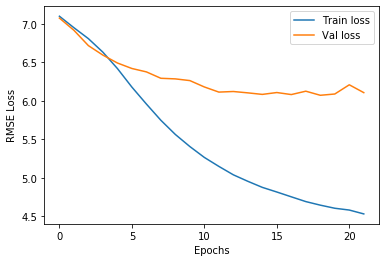

In [23]:
epochs = np.arange(1,len(train_losses))
plt.plot(train_losses)
plt.plot(val_losses)
plt.legend(['Train loss', 'Val loss'], loc='upper right')
plt.xlabel("Epochs")
plt.ylabel("RMSE Loss")
plt.show()

In [24]:
evaluator = Evaluator(model, criterion, test_loader, device)
test_loss = evaluator.evaluate()
loss_type = type(criterion).__name__
print(f'STTSModel {loss_type}: {test_loss:.4f}')

STTSModel RMSELoss: 6.0898
